# Data Analysys: A Bayesian Tutorial $\rightarrow$ # Chapter 2  Walkthrough: Parameter Estimation I

#### notebook setup

In [1]:
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.misc
import scipy.optimize as op
import random
from IPython.display import display, Math, Latex
from mpl_toolkits.mplot3d import Axes3D
import os

# plotting options
np.set_printoptions(precision=4, linewidth=120)
plt.rc('font'  , size=18)
plt.rc('figure', figsize=(10, 8))
plt.rc('axes'  , labelsize=22)
plt.rc('legend', fontsize=16)

np.set_printoptions(precision=4)
plt.rc('figure', figsize=(10, 8))

In [2]:
os.chdir('%s/examples/data_analysis_a_bayesian_tutorial' % os.getenv('DST'))
print(os.getcwd())

C:\Users\J28976\Documents\Development\dst\examples\data_analysis_a_bayesian_tutorial


#### tex setup
$ \newcommand{\prob}{\mathbb{P}} $

## 2.1 Coin Flip Example

### "Thuth Info"

In [3]:
H = 0
T = 1

# true parameter for the coin
p_true = 0.4

# number of data points generated
N = 4

# seed
seed = 1

### Calculate the likelihood Analytically

\begin{align}
\mathbb{P}(\{{\rm data}\} |\ p,\ I) &= \prod_i\mathbb{P}(x_i\ |\ p,\ I) \\
&= p^R (1 - p)^{N-R}
\end{align}

Where $R$ is the number of observed *heads*.  Note that this is the same as a [Beta Function](http://en.wikipedia.org/wiki/Beta_distribution) with

* $\beta  = N - R + 1$
* $\alpha = R + 1$

In this example, we can calculate the Maximum Likelihood analytically and use it to get an estimate of the true $p$:

$$\hat{p}_{\rm MLE} = \frac{R}{N}$$ 

### Calculate Prior

Take the prior to be flat:

\begin{align}
\mathbb{P}(p\ |\ I) = 
\left\{
\begin{array}{cc}
1 & 0 \leq p \leq 1 \\
0 & {\rm otherwise} \\
\end{array}
\right.
\end{align}

### Calculate the posterior

\begin{align}
\prob(\{p\ |\ \{{\rm data}\} ,\ I) &\propto \mathbb{P}(\{{\rm data}\} |\ p,\ I)\ \mathbb{P}(p\ |\ I)
\end{align}

### Coin Example code

In [4]:
class CoinPosterior(object):
    
    def __init__(self, p_true, N, seed=3):
        self.p_true = p_true
        self.N = N
        self.seed = seed
        
        np.random.seed(self.seed)
        data      = st.bernoulli.rvs(p=p_true, size=N)
        R         = np.sum(data)
        self.data = data
        self.R    = R
        
        p         = np.linspace(0,1,100000)
        like      = p**R * (1-p)**(N-R)
        prior     = np.ones_like(p)
        post      = like*prior
        self.norm = trapz(post, x = p)
        
    def mode(self):
        return self.R/float(self.N)
         
    def get_posterior(self, p):
        R     = self.R
        N     = self.N
        norm  = self.norm
        like  = p**R * (1-p)**(N-R)
        prior = np.ones_like(p)
        post  = like*prior/norm
        return post
    
    def __call__(self, p):
        return self.get_posterior(p)

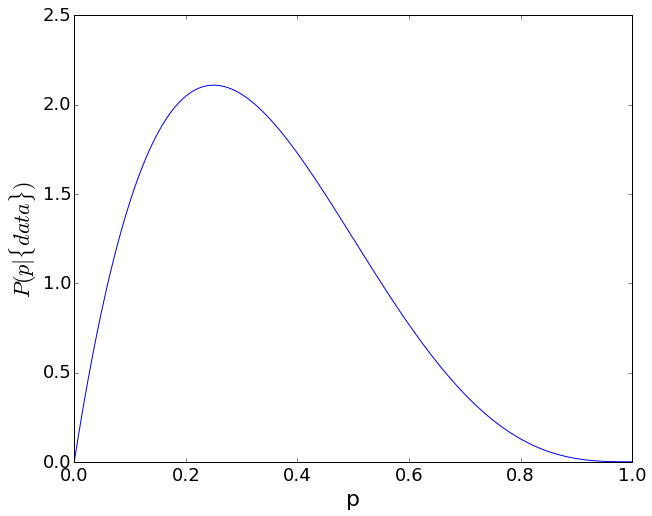

In [5]:
p = np.linspace(0,1,1000)
P = CoinPosterior(p_true, N, seed)
post = P(p)
plt.plot(p, post)
plt.xlabel('p')
plt.ylabel(r'$P(p | \{data\})$')
plt.show()

In [6]:
# test norm
np.trapz(post, x=p)

0.99999833016231887

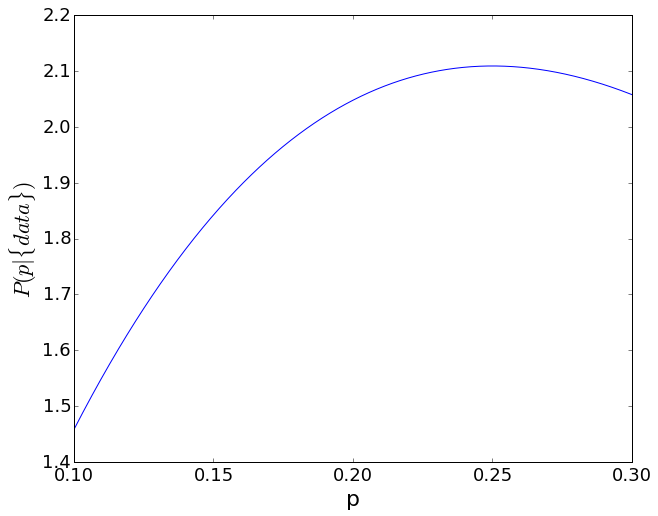

In [7]:
p = np.linspace(0.1,0.3,1000)
P = CoinPosterior(p_true, N, seed)
post = P(p)
plt.plot(p, post)
plt.xlabel('p')
plt.ylabel(r'$P(p | \{data\})$')
plt.show()

### Cheesy Confidence Interval Calculation

In [8]:
CL     = 0.90
N_grid = 200
xL     = np.linspace(0, 1, N_grid)
xR     = np.linspace(0, 1, N_grid)
x_diff = np.zeros((N_grid,N_grid))
area   = np.zeros_like(x_diff)

coin_post = CoinPosterior(p_true, N, seed)

for j, x_left in enumerate(xL):
    for i, x_right in enumerate(xR):
        if x_right <= x_left: 
            continue
        p           = np.linspace(x_left, x_right, 10000)
        x_diff[i,j] = x_right - x_left
        area[i,j]   = np.trapz(coin_post(p), x=p)

In [9]:
XL, XR   = np.meshgrid(xL, xR)
areaCL   = area.copy()   ; areaCL  [area >  CL] = np.NaN
x_diffCL = x_diff.copy() ; x_diffCL[area <= CL] = np.NaN
XL_CL    = XL.copy()     ; XL_CL   [area <= CL] = np.NaN
XR_CL    = XR.copy()     ; XR_CL   [area <= CL] = np.NaN

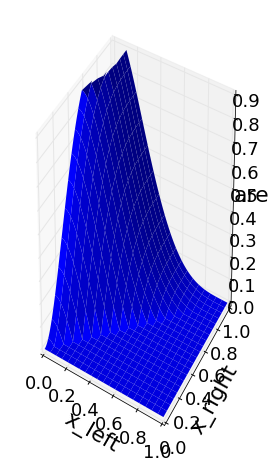

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
pl = ax.plot_surface(XL, XR, areaCL, linewidth=0)
ax.set_xlabel("x_left")
ax.set_ylabel("x_right")
ax.set_zlabel("area")
plt.show(pl)

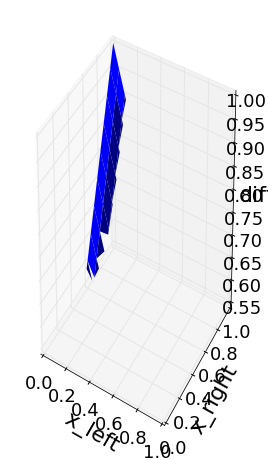

In [11]:
# %matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
pl = ax.plot_surface(XL, XR, x_diffCL, linewidth=0)
ax.set_xlabel("x_left")
ax.set_ylabel("x_right")
ax.set_zlabel("diff")
plt.show(pl)

In [12]:
xL_CL = XL_CL.ravel()[np.nanargmin(x_diffCL)]
xR_CL = XR_CL.ravel()[np.nanargmin(x_diffCL)]
xL_CL, P.mode(), xR_CL

(0.045226130653266333, 0.25, 0.60804020100502509)

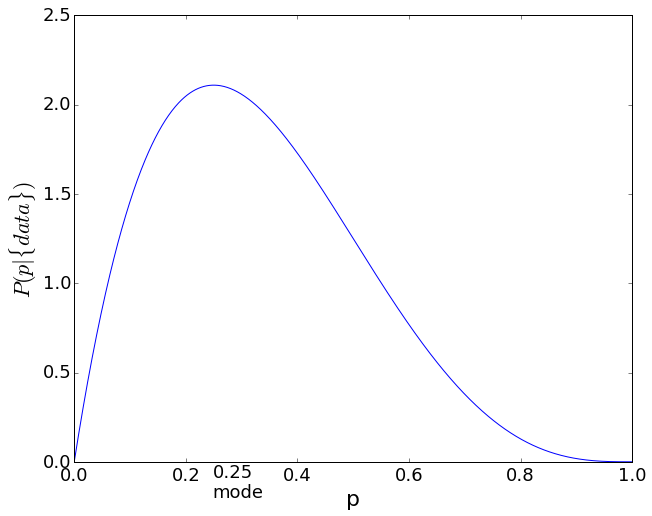

In [13]:
p = np.linspace(0,1,1000)
P = CoinPosterior(p_true, N, seed)
post = P(p)
plt.plot(p, post)
plt.xlabel('p')
plt.ylabel(r'$P(p | \{data\})$')
plt.text(P.mode(), -0.2, "%1.2f\nmode"%P.mode())
plt.show()

### figure 2.1

Show the posterior probability as a the number observed increases

In [14]:
import scipy.integrate

class CoinPosterior(object):
    
    def __init__(self, p_true, N, seed=3):
        self.p_true = p_true
        self.N = N
        self.seed = seed
        
        np.random.seed(self.seed)
        data      = st.bernoulli.rvs(p=p_true, size=N)
        self.R    = np.sum(data)
        self.data = data
                
    def mode(self):
        return self.R/float(self.N)
         
    def get_posterior(self, p):
        R     = self.R
        N     = self.N
        like  = scipy.stats.beta.pdf(p, a=R+1, b=N-R+1)
        prior = np.ones_like(p)
        post  = like*prior
        return post
    
    def __call__(self, p):
        return self.get_posterior(p)

In [15]:
def plot_post(p, p_true, N_obs, seed, ax=plt):
    post = CoinPosterior(p_true, N_obs, seed)(p)
    ax.plot(p, post)
    ax.set_xlabel('p')
    ax.set_ylabel(r'$\mathbb{P}\left(p | \{data\}\right)$')
    if N_obs == 0:
        ax.set_ylim([0, 1.1])
    ax.set_xlim([0,1])
    ax.text(0.7*ax.get_xlim()[1], 0.8*ax.get_ylim()[1], 'N = %d'%N_obs, fontsize=16)

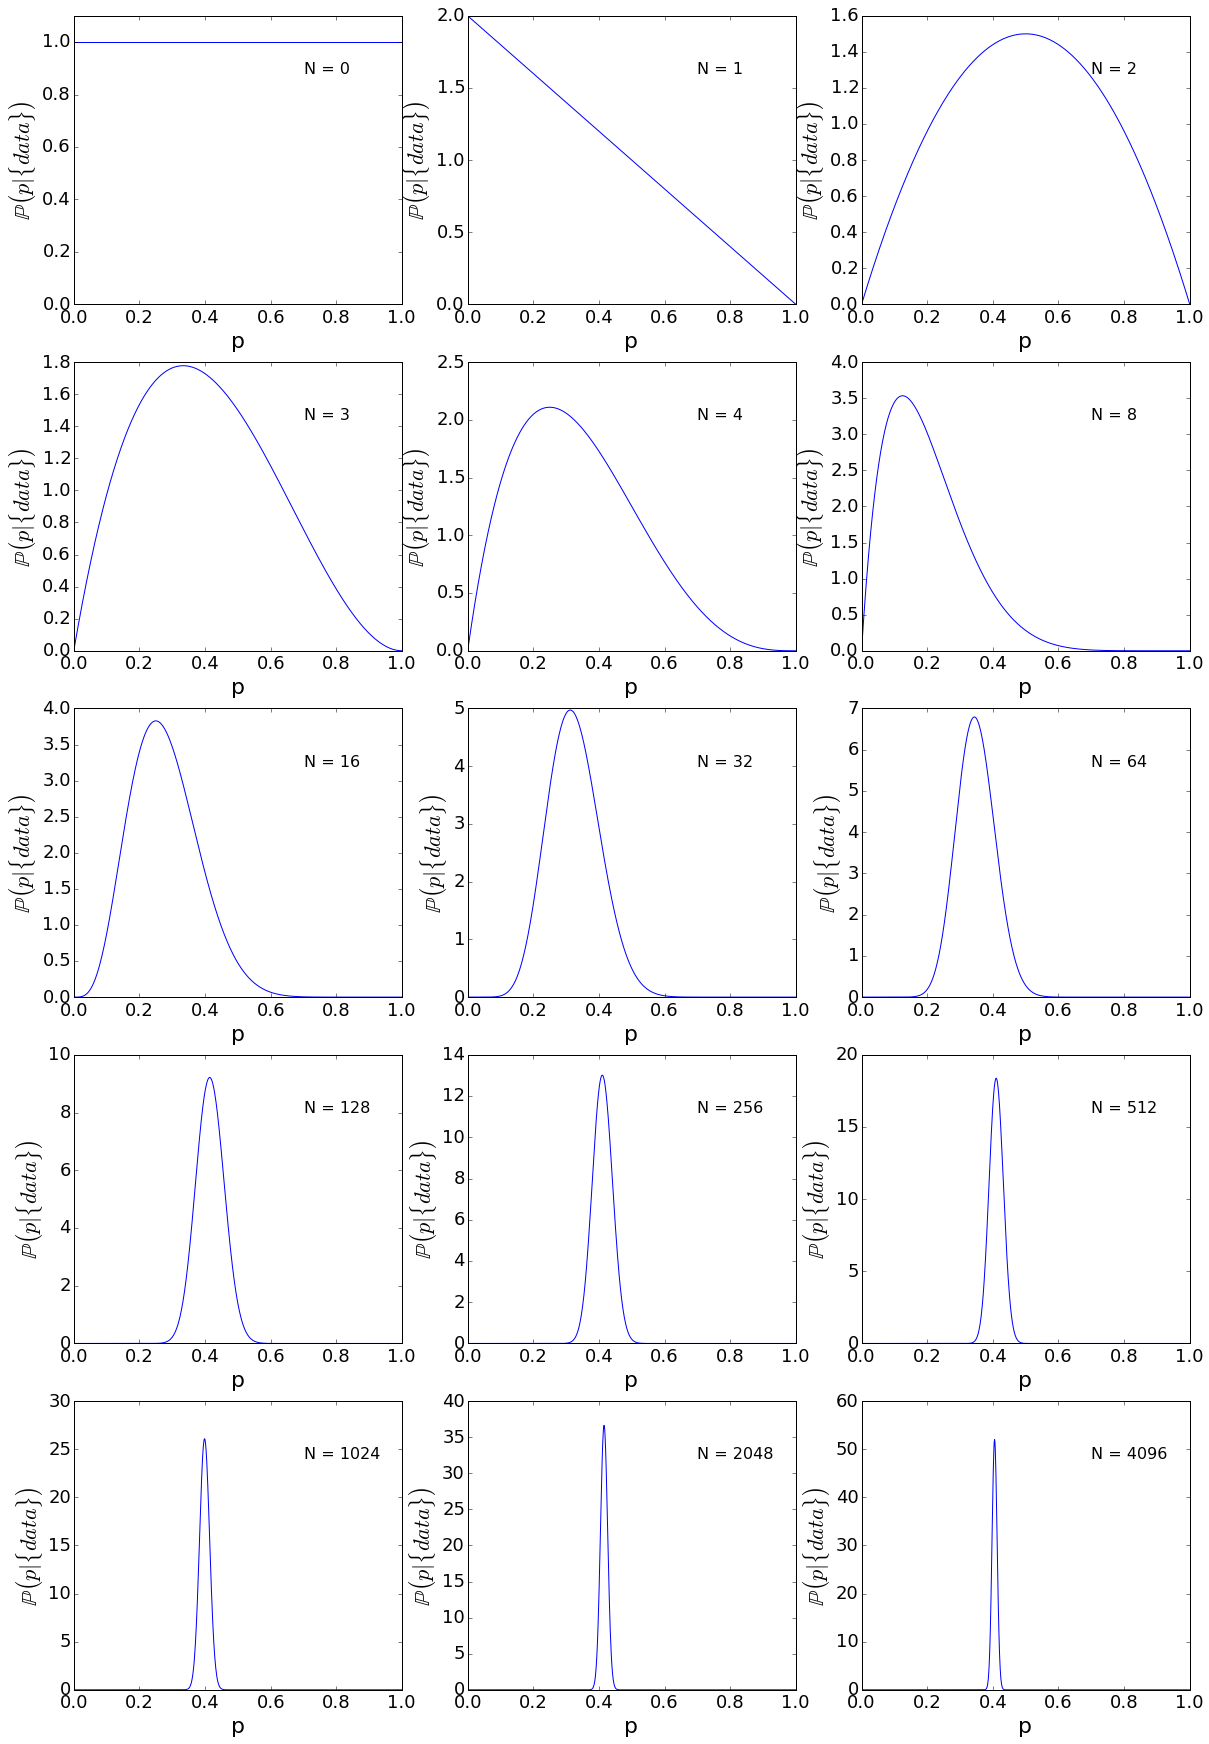

In [16]:
p = np.linspace(0,1,1000)    
fig, axes = plt.subplots(5,3)
fig.set_size_inches(20,30)
plot_post(p, p_true,    0, seed, axes[0,0])
plot_post(p, p_true,    1, seed, axes[0,1])
plot_post(p, p_true,    2, seed, axes[0,2])
plot_post(p, p_true,    3, seed, axes[1,0])
plot_post(p, p_true,    4, seed, axes[1,1])
plot_post(p, p_true,    8, seed, axes[1,2])
plot_post(p, p_true,   16, seed, axes[2,0])
plot_post(p, p_true,   32, seed, axes[2,1])
plot_post(p, p_true,   64, seed, axes[2,2])
plot_post(p, p_true,  128, seed, axes[3,0])
plot_post(p, p_true,  256, seed, axes[3,1])
plot_post(p, p_true,  512, seed, axes[3,2])
plot_post(p, p_true, 1024, seed, axes[4,0])
plot_post(p, p_true, 2048, seed, axes[4,1])
plot_post(p, p_true, 4096, seed, axes[4,2])
plt.show()

### figure 2.2

Now repeat figure 2.1 with varying priors

In [17]:
def flat_prior(p):
    return np.ones_like(p)

In [18]:
class beta_prior:
    
    def __init__(self, alpha, beta):
        self.a = alpha
        self.b = beta
        
    def __call__(self, p):
        return scipy.stats.beta.pdf(p, self.a, self.b)

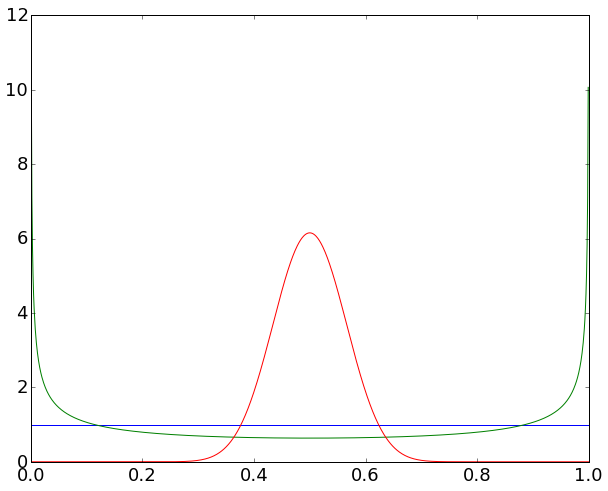

In [19]:
p  = np.linspace(0, 1, 1000)
f  = flat_prior(p)
b1 = beta_prior(alpha=0.5, beta=0.5)(p)
b2 = beta_prior(alpha=30 , beta=30 )(p)
plt.plot(p, f)
plt.plot(p, b1)
plt.plot(p, b2)
plt.show()

In [20]:
class CoinPosterior(object):
    
    def __init__(self, p_true, N, prior_func=flat_prior, seed=3):
        self.p_true = p_true
        self.N = N
        self.seed = seed
        
        np.random.seed(self.seed)
        data            = st.bernoulli.rvs(p=p_true, size=N)
        R               = np.sum(data)
        self.data       = data
        self.R          = R
        self.prior_func = prior_func
        
    def mode(self):
        return self.R/float(self.N)
         
    def get_posterior(self, p):
        R     = self.R
        N     = self.N
        like  = scipy.stats.beta.pdf(p, a=R+1, b=N-R+1)
        prior = self.prior_func(p)
        post  = prior if N==0 else like*prior
        return post
    
    def __call__(self, p):
        return self.get_posterior(p)

In [21]:
def plot_post(p, p_true, N_obs, seed, ax=plt):
    post_flat  = CoinPosterior(p_true=p_true, N=N_obs, prior_func=flat_prior          , seed=seed)(p)
    post_1side = CoinPosterior(p_true=p_true, N=N_obs, prior_func=beta_prior(0.5, 0.5), seed=seed)(p)
    post_fair  = CoinPosterior(p_true=p_true, N=N_obs, prior_func=beta_prior(30 , 30 ), seed=seed)(p)
    
    ax.plot(p, post_flat)
    ax.plot(p, post_fair)
    ax.plot(p, post_1side)
    ax.set_xlabel('p')
    ax.set_ylabel(r'$\mathbb{P}\left(p | \{data\}\right)$')
#     if N_obs == 0:
#         ax.set_ylim([0, 1.1])
    ax.set_xlim([0,1])
    ax.text(0.7*ax.get_xlim()[1], 0.8*ax.get_ylim()[1], 'N = %d'%N_obs, fontsize=16)

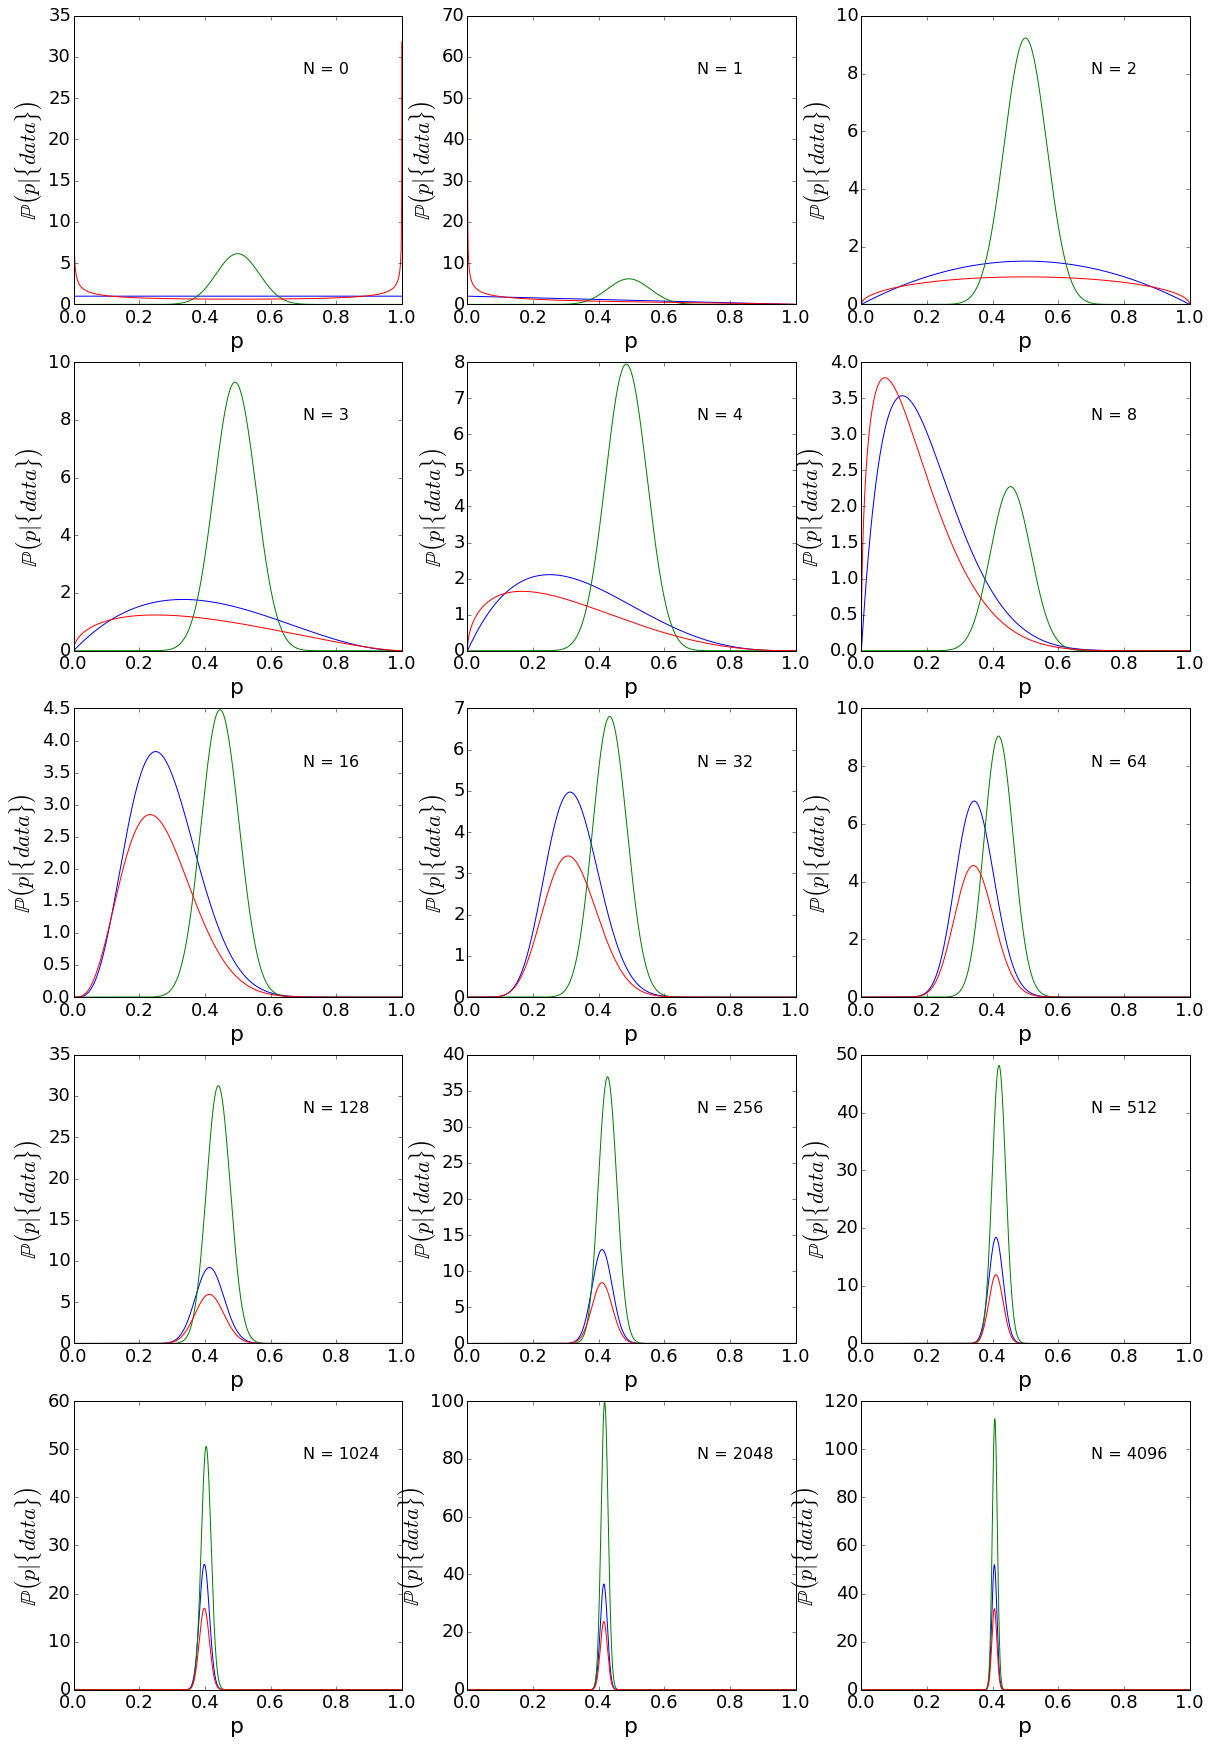

In [22]:
p = np.linspace(0,1,10000)    
fig, axes = plt.subplots(5,3)
fig.set_size_inches(20,30)
plot_post(p, p_true,    0, seed, axes[0,0])
plot_post(p, p_true,    1, seed, axes[0,1])
plot_post(p, p_true,    2, seed, axes[0,2])
plot_post(p, p_true,    3, seed, axes[1,0])
plot_post(p, p_true,    4, seed, axes[1,1])
plot_post(p, p_true,    8, seed, axes[1,2])
plot_post(p, p_true,   16, seed, axes[2,0])
plot_post(p, p_true,   32, seed, axes[2,1])
plot_post(p, p_true,   64, seed, axes[2,2])
plot_post(p, p_true,  128, seed, axes[3,0])
plot_post(p, p_true,  256, seed, axes[3,1])
plot_post(p, p_true,  512, seed, axes[3,2])
plot_post(p, p_true, 1024, seed, axes[4,0])
plot_post(p, p_true, 2048, seed, axes[4,1])
plot_post(p, p_true, 4096, seed, axes[4,2])
plt.show()

## Example 3: the light house

**question**:

A lighthouse is somewhere off a piece of straight coastline at a position $\alpha$ along the shore and a distance $\beta$ out at sea. It emits a series of short highly collimated flashes at random intervals and hence at random azimuths. These pulses are intercepted on the coast by photo-detectors that record only the fact that a flash has occurred, but not the angle from which it came. N flashes have so far been recorded at positions {xk}. Where is the lighthouse?

See the following figure for a illustration of the setup:

<img src="fig2p7.png" width=900/>

Let us assume that the azimuth angle of the light house of the kth data $\theta_k$ is given by:

$$\prob(\theta_k | \alpha, \beta, I) = \frac{1}{\pi}$$

where the angle must lie between $\pm \pi/2$ to have been detected.  Now we can relate $x_{k}$ to $\theta_k$ using:

\begin{align}
\beta \tan \theta_k &= x_k - \alpha
\end{align}

Changing variables by differentiating both sides, we can write the PDF in terms of $x_k$ as follows

\begin{align}
\int_{-\frac{\pi}{2}}^{+\frac{\pi}{2}} \prob(\theta | \alpha, \beta, I)\ d\theta 
= \int_{-\frac{\pi}{2}}^{+\frac{\pi}{2}} \frac{1}{\pi}\ d\theta
= 1
\end{align}

Now consider the differential of both sides:

\begin{align}
\tan \theta &= \left(\frac{x - \alpha}{\beta}\right) \\
\sec^2 \theta d\theta &= \frac{dx}{\beta} \\
d\theta &= \left(\frac{\beta^2}{\beta^2 + (x - \alpha)^2}\right)\frac{dx}{\beta}
\end{align}

so 

\begin{align}
\int_{-\frac{\pi}{2}}^{+\frac{\pi}{2}} \frac{1}{\pi}\ d\theta
&= \int_{-\infty}^{+\infty} \frac{1}{\pi}\left(\frac{\beta}{\beta^2 + (x - \alpha)^2}\right)\ dx
\end{align}

so reading off, we have

$$\prob(x_k | \alpha, \beta, I) = \frac{1}{\pi}\left(\frac{\beta}{\beta^2 + (x - \alpha)^2}\right)$$

Notice that this is a *Cauchy* distribution.

<img src="fig2p8.png" width=900/>

To keep this a one parameter problem, let us assume that $\beta$ is known and the only unknown parameter to infer is $\alpha$.  

Writing down Bayes' Theroem:

$$\prob(\alpha | \{x_k\}, \beta, I) = \prob(\{x_k\} | \alpha, \beta, I) \times \prob(\alpha | \beta, I)$$.

#### prior:

The data tells us nothing new about $\alpha$ and with holding $\beta$ fixed, we assume a flat prior:

\begin{align}
\prob(\alpha | \beta, I) = \prob(\alpha | I) =
\left\{
\begin{array}{l}
A \qquad \alpha_{min} \leq \alpha \leq \alpha_{max} \\
0 \qquad \text{otherwise} \\
\end{array}
\right.
\end{align}

where $\alpha_{min/max}$ represent the limits of the coastline.

#### likelihood:

Each pulse is an independent event, so we can write the likelihood as:

$$\prob(\{x_k\} | \alpha, \beta, I) = \prod_{k=1}^N \prob(x_k | \alpha, \beta, I)$$

#### Posterior


Now computing the log of the posterior:

\begin{align}
L 
= \log \left[\prob(\alpha | \{x_k\}, \beta, I)\right]
= \text{contant} - \sum_{k=1}^N \log \left[ \beta^2 + (x_k - \alpha)^2 \right]
\end{align}

For this example, let us assume that the limits on the prior are large and we can ignore any cut-offs.  Then $\alpha$ can be infered by taking the maximum of L:

\begin{align}
\left.\frac{dL}{d\alpha}\right|_{\alpha_0}
= 2\sum_{k=1}^N \frac{x_k - \alpha_0}{\beta^2 + (x_k - \alpha_0)^2}
\end{align}

This is diffucult to solve for $\alpha_0$ analylically, so we create a numerical solution.

In [25]:
class LightHousePosterior(object):
    
    def __init__(self, alpha_true, beta, N_obs, seed=3):
        self.alpha_true = alpha_true
        self.beta       = beta
        self.N_obs      = N_obs
        self.seed       = seed
        
        loc   = alpha_true
        scale = 1.0/(beta)
        
        np.random.seed(self.seed)
        self.data = st.cauchy(loc=loc, scale=scale).rvs(size=N_obs)
        
    def mode(self, alpha):
        return np.max(self.get_posterior(alpha))
         
    def get_posterior(self, alpha):
        beta  = self.beta
        data  = self.data
        post  = [-np.sum(np.log(beta**2 + (data - a)**2)) for a in alpha]
        post  = post - np.max(post)
        post  = np.exp(post)
        return post
    
    def __call__(self, alpha):
        return self.get_posterior(alpha)

In [26]:
def plot_post(alpha, alpha_true, beta, N_obs, seed, ax=plt):
    post = LightHousePosterior(alpha_true=alpha_true, beta=beta, N_obs=N_obs, seed=seed)(alpha)
    
    ax.plot(alpha, post)
    ax.set_xlabel(r'$\alpha$ (km)')
    ax.set_ylabel(r'$\mathbb{P}\left(\alpha| \{x_k\}, \beta, I \right)$')
    ax.set_xlim([np.min(alpha), np.max(alpha)])
    ax.text(0.7*ax.get_xlim()[1], 0.8*ax.get_ylim()[1], 'N = %d'%N_obs, fontsize=16)

In [27]:
alpha_true = 1.0
beta_true  = 1.0
seed       = 5

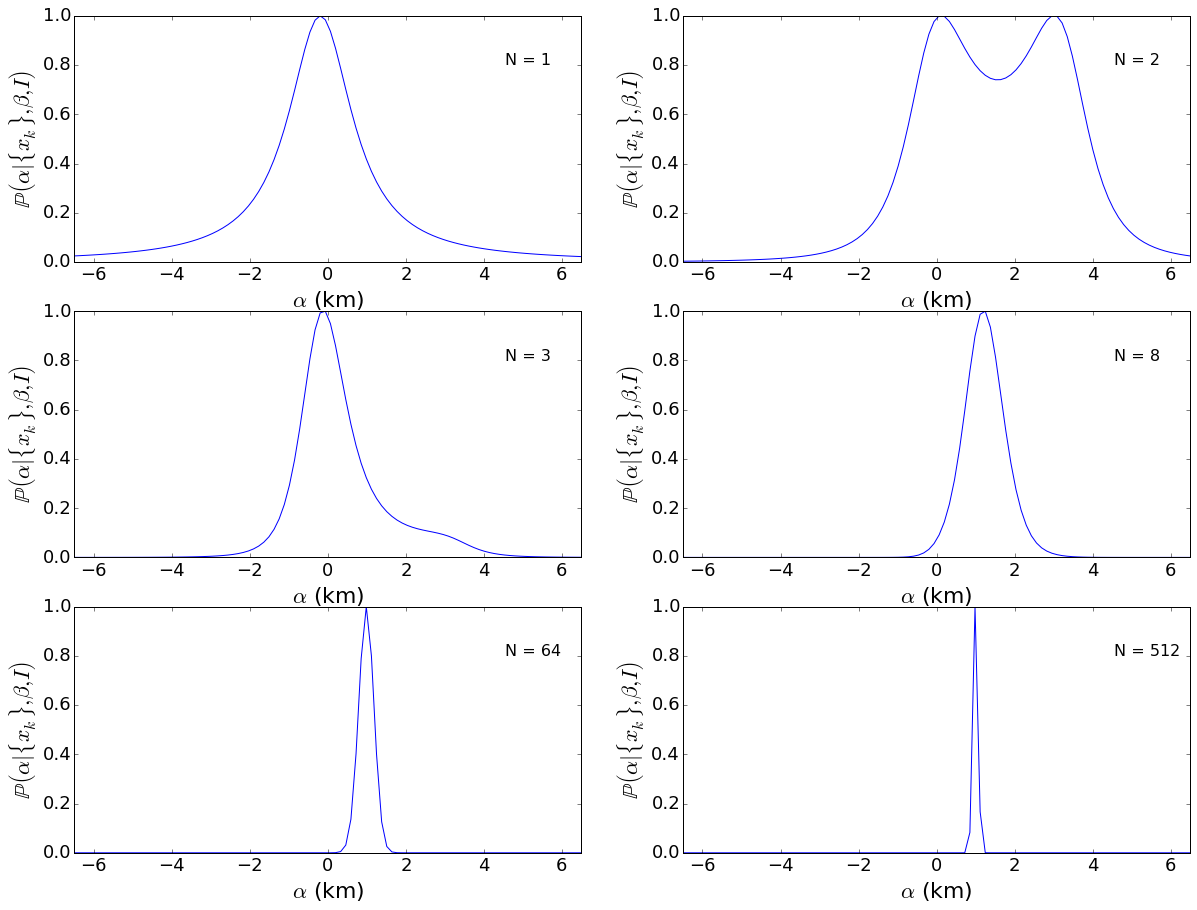

In [28]:
alpha = np.linspace(-6.5, 6.5, 100)

fig, axes = plt.subplots(3,2)
fig.set_size_inches(20,15)
plot_post(alpha, alpha_true, beta_true, N_obs=  1, seed=seed, ax=axes[0,0])
plot_post(alpha, alpha_true, beta_true, N_obs=  2, seed=seed, ax=axes[0,1])
plot_post(alpha, alpha_true, beta_true, N_obs=  3, seed=seed, ax=axes[1,0])
plot_post(alpha, alpha_true, beta_true, N_obs=  8, seed=seed, ax=axes[1,1])
plot_post(alpha, alpha_true, beta_true, N_obs= 64, seed=seed, ax=axes[2,0])
plot_post(alpha, alpha_true, beta_true, N_obs=512, seed=seed, ax=axes[2,1])